<a href="https://colab.research.google.com/github/matansuliman/Introduction-to-Machine-Learning/blob/main/SVM_Sequential_minimal_optimization_(SMO)_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview:


**This is a SVM implementation with SMO and Linear Classifaiers using the Iris flower data set.**


**This notebook has 3 parts:**
1.   Initialization
2.   SMO implementation
3.   Linear classifiers using Iris flower data set

**notes:**
- The SMO implementation is based on the article "Sequential Minimal Optimization: A Fast Algorithm for
Training Support Vector Machines", 1998, by John C. Platt. https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf

- The Iris flower data set is introduced by Ronald Fisher

## Initialization

### dependencies

**Imports**

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd
from tqdm.notebook import tqdm

**Global variables**

In [ ]:
np.random.seed(42) # ensures reproducibility

## Part A: Implement the Sequential Minimal Optimization (SMO) algorithm

In [ ]:
def linear_kernel(x1, x2):
  """
  Computes the linear kernel between two data points.

  Args:
      x1, x2: First and Second data point.

  Returns:
      The linear kernel value (dot product).
  """
  return np.dot(x1, x2.T)

In [ ]:
def objective_function(alpha1, alpha2, y1, y2, k11, k12, k22, b, s, bound):
  """
  Calculates the objective function value for the SMO algorithm.

  Args:
      alpha1, alpha2: Lagrange multipliers for the two data points.
      y1, y2: Class labels for the two data points.
      k11, k12, k22: Kernel values between the two data points.
      b: Bias term.
      s: Product of the class labels (y1 * y2).
      bound: Upper bound for the Lagrange multipliers.

  Returns:
      The objective function value.
  """
  return (alpha1 +s *(alpha2 -bound))**2                   *k11 /2 + \
          (alpha2 -bound)**2                               *k22 /2 + \
          s *(alpha1 +s *(alpha2 -bound)) *(alpha2 -bound) *k12 + \
          (alpha1 +s *(alpha2 -bound)) *y1 *b + \
          (alpha2 -bound) *y2 *b

In [ ]:
def calculate_E(i, X, y, alphas, b, kernel):
  """
  Calculates the error for a given data point.

  Args:
      i: Index of the data point.
      X: Input data matrix.
      y: Class labels.
      alphas: Lagrange multipliers.
      b: Bias term.
      kernel: Kernel function.

  Returns:
      The error value.
  """
  return np.dot(alphas *y, kernel(X, X[i])) +b -y[i]

In [ ]:
def takeStep(i1, i2, X, y, alphas, b, C, tol, kernel):
  """
  Optimizes the Lagrange multipliers for two data points.

  Args:
      i1, i2: Indices of the two data points.
      X: Input data matrix.
      y: Class labels.
      alphas: Lagrange multipliers.
      b: Bias term.
      C: Regularization parameter.
      tol: Tolerance for convergence.
      kernel: Kernel function.

  Returns:
      1 if the optimization step was successful, 0 otherwise.
  """

  # If i1 and i2 are the same, no optimization needed
  if i1 == i2: return 0

  alpha1, alpha2 = alphas[i1], alphas[i2]
  y1, y2 = y[i1], y[i2]
  E1, E2 = calculate_E(i1, X, y, alphas, b, kernel), calculate_E(i2, X, y, alphas, b, kernel)
  s = y1 * y2

  # Compute L and H based on whether y1 and y2 are equal
  if y1 != y2:
    L = max(0, alpha2 -alpha1)
    H = min(C, C +alpha2 -alpha1)
  else:
    L = max(0, alpha1 +alpha2 -C)
    H = min(C, alpha1 +alpha2)

  # If L and H are equal, no optimization possible
  if L == H: return 0

  k11, k12, k22 = kernel(X[i1], X[i1]), kernel(X[i1], X[i2]), kernel(X[i2], X[i2])
  eta = k11 +k22 -2 *k12

  # Update alpha2 based on eta
  if eta > 0:
    a2 = alpha2 +y2 *(E1 -E2) /eta
    a2 = np.clip(a2, L, H) # Clip a2 to the bounds L and H
  else:
    # Objective function at a2 = L and H (simplified for linear kernel)
    L_obj = objective_function(alpha1, alpha2, y1, y2, k11, k12, k22, b, s, L)
    H_obj = objective_function(alpha1, alpha2, y1, y2, k11, k12, k22, b, s, H)

    # Update a2 based on the objective function values
    if L_obj < H_obj -tol: a2 = L # If L_obj is significantly smaller than H_obj, set a2 to L
    elif L_obj > H_obj +tol: a2 = H # If L_obj is significantly larger than H_obj, set a2 to H
    else: a2 = alpha2 # Otherwise, keep a2 unchanged

  # Check if the change in alpha2 is significant
  if abs(a2 -alpha2) < tol *(a2 +alpha2 +tol):
    return 0 # If the change is too small, no optimization occurred

  # Update alpha1 based on alpha2
  a1 = alpha1 +s *(alpha2 -a2)

  # Update b
  b1 = b -E1 -y1 *(a1 -alpha1) *k11 -y2 *(a2 -alpha2) *k12
  b2 = b -E2 -y1 *(a1 -alpha1) *k12 -y2 *(a2 -alpha2) *k22

  # Update b based on the values of a1 and a2
  if 0 < a1 < C: b = b1 # If a1 is within the bounds, use b1
  elif 0 < a2 < C: b = b2 # If a2 is within the bounds, use b2
  else: b = (b1 +b2) /2 # Otherwise, use the average of b1 and b2

  # Update alphas in the original array
  a1 = a1.item() if isinstance(a1, np.ndarray) else a1 # Ensure a1 is a scalar
  a2 = a2.item() if isinstance(a2, np.ndarray) else a2 # Ensure a2 is a scalar
  alphas[i1], alphas[i2] = a1, a2 # Update alphas with the new values

  return 1 # Optimization step was successful

In [ ]:
def select_i1(i2, E2, non_bound_indices, X, y, alphas, b, kernel):
  """
  Selects the first data point for optimization based on error difference.

  Args:
      i2: Index of the second data point.
      E2: Error for the second data point.
      non_bound_indices: Indices of data points with non-bound Lagrange multipliers.
      X: Input data matrix.
      y: Class labels.
      alphas: Lagrange multipliers.
      b: Bias term.
      kernel: Kernel function.

  Returns:
      The index of the selected first data point.
  """


  # Initialize variables for finding the best i1
  max_diff = -1
  i1 = -1
  # Iterate through non-bound indices to find i1 that maximizes |E1 - E2|
  for i in non_bound_indices:
    if i != i2:
      E1 = calculate_E(i, X, y, alphas, b, kernel)
      diff = abs(E1 -E2)
      if diff > max_diff:
        max_diff = diff
        i1 = i
  return i1

In [ ]:
def examineExample(i2, X, y, alphas, b, C, tol, kernel):
  """
  Examines a data point for potential optimization.

  Args:
      i2: Index of the data point to examine.
      X: Input data matrix.
      y: Class labels.
      alphas: Lagrange multipliers.
      b: Bias term.
      C: Regularization parameter.
      tol: Tolerance for convergence.
      kernel: Kernel function.

  Returns:
      1 if the data point was optimized, 0 otherwise.
  """

  y2 = y[i2]
  alph2 = alphas[i2]
  E2 = calculate_E(i2, X, y, alphas, b, kernel)
  r2 = E2 *y2

  # Check if the KKT conditions are violated for data point i2
  # KKT conditions are violated if (r2 < -tol and alph2 < C) or (r2 > tol and alph2 > 0)
  if ((r2 < -tol and alph2 < C) or (r2 > tol and alph2 > 0)):

    # Get indices of non-bound alphas (0 < alpha < C)
    non_bound_indices = np.where((alphas > 0) & (alphas < C))[0]

    # If there are more than 1 non-bound alphas, use the second choice heuristic
    if len(non_bound_indices) > 1:
      # Second choice heuristic (choose i1 that maximizes |E1 - E2|)
      i1 = select_i1(i2, E2, non_bound_indices, X, y, alphas, b, kernel)
      # Attempt to optimize with the selected i1 and i2
      if takeStep(i1, i2, X, y, alphas, b, C, tol, kernel):
        return 1 # Optimization successful

    # If the second choice heuristic failed or there are not enough non-bound alphas
    # Loop over non-zero and non-C alphas
    for i1 in non_bound_indices:
      if takeStep(i1, i2, X, y, alphas, b, C, tol, kernel):
        return 1

    # If the previous loops failed to optimize
    # Loop over all alphas
    for i1 in range(len(alphas)):
      if takeStep(i1, i2, X, y, alphas, b, C, tol, kernel):
          return 1

  return 0 # No optimization occurred for i2

In [ ]:
def SMO(X, y, C, tol, max_iter, class_str, kernel):
  """
  Implements the Sequential Minimal Optimization (SMO) algorithm.

  Args:
      X: Input data matrix.
      y: Class labels.
      C: Regularization parameter.
      tol: Tolerance for convergence.
      max_iter: Maximum number of iterations.
      class_str: String representing the class label.
      kernel: Kernel function.

  Returns:
      The optimized Lagrange multipliers (alphas) and bias term (b).
  """

  # Initialize variables
  n_samples, n_features = X.shape
  alphas = np.zeros(n_samples)
  b = 0
  examineAll = True
  numChanged = 0

  # Iterate until max_iter or convergence
  for _ in tqdm(range(max_iter), desc=f"    SMO of {class_str} with C={C}, tol={tol}", leave= False):  # Add description for clarity

    if numChanged > 0 or examineAll:

      numChanged = 0 # Reset the counter for this iteration

      # If examining all examples:
      if examineAll:
        for i2 in range(n_samples):
          numChanged += examineExample(i2, X, y, alphas, b, C, tol, kernel)
      # If examining only non-bound examples:
      else:
        non_bound_indices = np.where((alphas > 0) & (alphas < C))[0]
        for i2 in non_bound_indices:
          numChanged += examineExample(i2, X, y, alphas, b, C, tol, kernel)

      if examineAll:
        examineAll = False
      elif numChanged == 0:
        examineAll = True

    else:
      tqdm._instances.clear()
      break

  return alphas, b

##Part B: address linear classifiers using Iris flower data set

### section a - visulaize the data

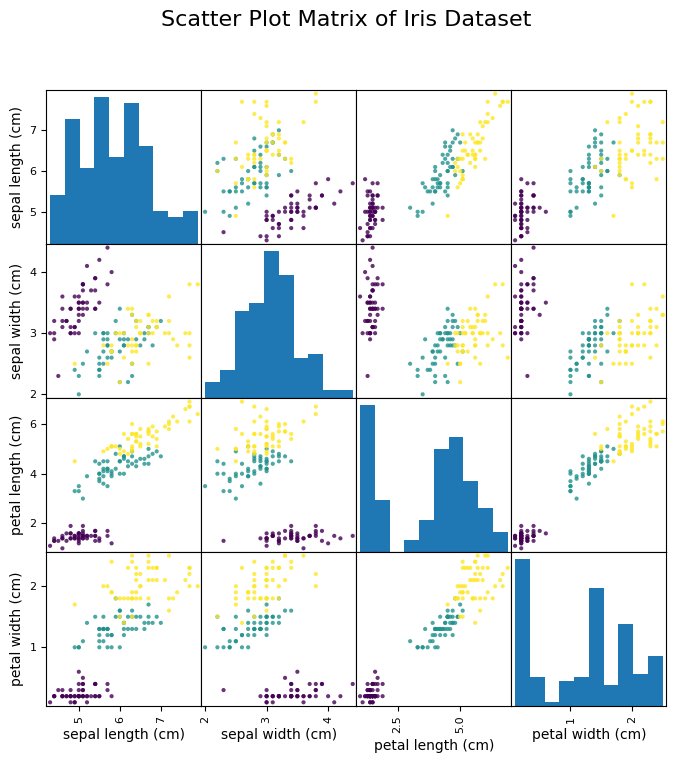

In [ ]:
iris = datasets.load_iris()

# Create a Pandas DataFrame for easier plotting
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]  # Add species names as a column

# Create the scatter plot matrix
colors = ['red', 'green', 'blue']  # Colors for each species
scatter_matrix(iris_df, c=iris_df['species'].map({name: i for i, name in enumerate(iris.target_names)}), figsize=(8, 8), alpha=.8)

plt.suptitle('Scatter Plot Matrix of Iris Dataset', fontsize=16)
plt.show()

**Most Separable Species:**

---


From the scatter plot matrix, you'll likely observe that Iris setosa is the most separable species. Its data points form distinct clusters compared to the other two species (Iris versicolor and Iris virginica), which have more overlap.

### section b - tune C with val set

#### init the variabels

extract X and y

In [ ]:
X = iris.data
y = iris.target

standardization

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split: train - 60%, val - 20%, test - 20%

In [ ]:
# Split into training and remaining data (80% - 20%)
X_train, X_remaining, y_train, y_remaining = train_test_split(X_scaled, y, train_size= 0.8, test_size=0.2, random_state=42)

In [ ]:
# Split the remaining data into validation and test sets (50% - 50%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

helper one hot encoding function

In [ ]:
binary = lambda y, class_label: np.where(y == class_label, 1, -1)

Hyper aramaters

In [ ]:
C_values = np.linspace(0.01, 10, 5).tolist()
tol_hyper = 1e-3
max_iter_hyper = 75

define a prediction function

In [ ]:
def predict(X, class_label, alphas, b, kernel):
  if X.ndim == 1:
    return np.sign(np.dot(alphas * binary(y_train, class_label), kernel(X_train, X)) + b)
  elif X.ndim == 2:
    return [predict(x, class_label, alphas, b, kernel) for x in X]
  else:
    return print(X.ndim)

#### Tuning the C parameter

In [ ]:
num_classes = len(np.unique(y_train))

# Store the best C value for each class
best_C_values = []
best_classifiers = []

for class_label in tqdm(range(num_classes), desc=f"Training Classes"):
  best_C = -1  # Initialize best C for this class
  best_classifier = ()  # Initialize best classifier for this class
  best_accuracy = 0  # Initialize best accuracy for this class

  for C in tqdm(C_values, desc=f"   Tune C for class {class_label}"):

    # Train the SVM with the current C value - SMO
    alphas, b = SMO(X= X_train,
                    y= binary(y_train, class_label),
                    C= C,
                    tol= tol_hyper,
                    max_iter= max_iter_hyper,
                    class_str= class_label,
                    kernel= linear_kernel
                    )

    # Make predictions on the validation set
    predictions = predict(X_val, class_label, alphas, b, linear_kernel)

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(binary(y_val, class_label), predictions)

    # Update best C if accuracy is higher
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_C = C
      best_classifier = (alphas, b)

  best_C_values.append(best_C)
  best_classifiers.append(best_classifier)

print("Best C values for each class:", best_C_values)

Training Classes:   0%|          | 0/3 [00:00<?, ?it/s]

   Tune C for class 0:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 0 with C=0.01, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 0 with C=2.5075, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 0 with C=5.005, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 0 with C=7.5024999999999995, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 0 with C=10.0, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

   Tune C for class 1:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 1 with C=0.01, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 1 with C=2.5075, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 1 with C=5.005, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 1 with C=7.5024999999999995, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 1 with C=10.0, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

   Tune C for class 2:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 2 with C=0.01, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 2 with C=2.5075, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 2 with C=5.005, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 2 with C=7.5024999999999995, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

    SMO of 2 with C=10.0, tol=0.001:   0%|          | 0/75 [00:00<?, ?it/s]

Best C values for each class: [0.01, 2.5075, 0.01]


In [ ]:
test_predictions = []
for x in X_test:
  predictions = []
  for class_label in range(num_classes):
    alphas, b = best_classifiers[class_label]
    predictions.append(predict(x, class_label, alphas, b, linear_kernel))
  test_predictions.append(np.argmax(predictions))

### section c - confusion matrix and accuracy

Calculate confusion matrix, accuracy

In [ ]:
def calc_cm_acc(test_predictions):
  cm = confusion_matrix(y_test, test_predictions)
  accuracy = accuracy_score(y_test, test_predictions)

  print("Confusion Matrix:\n", cm)
  print("Accuracy:", accuracy)

In [ ]:
calc_cm_acc(test_predictions)

Confusion Matrix:
 [[5 0 0]
 [0 5 1]
 [0 1 3]]
Accuracy: 0.8666666666666667


### section d - table of confusion and sensetivity

In [ ]:
def calc_table_of_confusion_and_sensitivity(test_predictions):
  cm = confusion_matrix(y_test, test_predictions)
  table_of_confusion_per_class = []
  sensitivity_per_class = []

  for i in range(num_classes):
      TP = cm[i, i]  # True positives for class i
      FN = sum(cm[i, :]) - TP  # False negatives for class i
      FP = sum(cm[:, i]) - TP  # False positives for class i
      TN = np.sum(cm) - TP - FN - FP  # True negatives

      # Calculate sensitivity for class i
      sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # Handle potential division by zero
      sensitivity_per_class.append(sensitivity)

      # Calculate table of confusion for class i
      table_of_confusion_per_class.append(np.array([
          [TP, FN],
          [FP, TN]
      ]))

  for i in range(num_classes):
      print(f"Class {i}:")
      print(f"  Sensitivity: {sensitivity_per_class[i]}")
      print(f"  Table of Confusion:\n{table_of_confusion_per_class[i]}\n")

In [ ]:
calc_table_of_confusion_and_sensitivity(test_predictions)

Class 0:
  Sensitivity: 1.0
  Table of Confusion:
[[ 5  0]
 [ 0 10]]

Class 1:
  Sensitivity: 0.8333333333333334
  Table of Confusion:
[[5 1]
 [1 8]]

Class 2:
  Sensitivity: 0.75
  Table of Confusion:
[[ 3  1]
 [ 1 10]]



### section e - repeat b, c, d with RBF kernel and tune gamma

In [ ]:
gamma = 9
max_iter_hyper = 5

In [ ]:
def rbf_kernel(x1, x2):
  if x1.ndim == 1:
    return np.exp(-gamma * np.linalg.norm(x1 -x2)**2)
  elif x1.ndim == 2:
    return np.exp(-gamma * np.linalg.norm(x1[:, np.newaxis] -x2, axis= 2)**2)
  else:
    return print(x1.ndim)

In [ ]:
gamma_values = np.linspace(0.01, 1, 5).tolist()

In [ ]:
num_classes = len(np.unique(y_train))

# Store the best gamma value for each class
best_gamma_values = []
best_classifiers = []

for class_label in tqdm(range(num_classes), desc=f"Training Classes"):
  best_gamma = -1  # Initialize best gamma for this class
  best_classifier = ()  # Initialize best classifier for this class
  best_accuracy = 0  # Initialize best accuracy for this class

  for gamma_tmp in tqdm(gamma_values, desc=f"   Tune C for class {class_label}"):

    gamma = gamma_tmp
    # Train the SVM with the current C value - Use SMO function
    alphas, b = SMO(X= X_train,
                    y= binary(y_train, class_label),
                    C= best_C_values[class_label],
                    tol= tol_hyper,
                    max_iter= max_iter_hyper,
                    class_str= class_label,
                    kernel= rbf_kernel
                    )

    # Make predictions on the validation set
    predictions = predict(X_val, class_label, alphas, b, linear_kernel)

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(binary(y_val, class_label), predictions)

    # Update best C if accuracy is higher
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_gamma = gamma
      best_classifier = (alphas, b)

  best_gamma_values.append(best_gamma)
  best_classifiers.append(best_classifier)

print("Best gamma values for each class:", best_gamma_values)

Training Classes:   0%|          | 0/3 [00:00<?, ?it/s]

   Tune C for class 0:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 0 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 0 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 0 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 0 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 0 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

   Tune C for class 1:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 1 with C=2.5075, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 1 with C=2.5075, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 1 with C=2.5075, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 1 with C=2.5075, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 1 with C=2.5075, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

   Tune C for class 2:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 2 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 2 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 2 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 2 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

    SMO of 2 with C=0.01, tol=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

Best gamma values for each class: [0.01, 1.0, 0.01]


In [ ]:
test_predictions = []
for x in X_test:
  predictions = []
  for class_label in range(num_classes):
    gamma = best_gamma_values[class_label]
    alphas, b = best_classifiers[class_label]
    predictions.append(predict(x, class_label, alphas, b, rbf_kernel))
  test_predictions.append(np.argmax(predictions))

In [ ]:
calc_cm_acc(test_predictions)

Confusion Matrix:
 [[5 0 0]
 [0 6 0]
 [0 0 4]]
Accuracy: 1.0


In [ ]:
calc_table_of_confusion_and_sensitivity(test_predictions)

Class 0:
  Sensitivity: 1.0
  Table of Confusion:
[[ 5  0]
 [ 0 10]]

Class 1:
  Sensitivity: 1.0
  Table of Confusion:
[[6 0]
 [0 9]]

Class 2:
  Sensitivity: 1.0
  Table of Confusion:
[[ 4  0]
 [ 0 11]]

